In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import geopandas as gpd

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv('listings_cleaned.csv', index_col = 'id')
df.head()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,city,property_type,...,hot_tub_sauna_or_pool,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,event_suitable,time_since_first_review,time_since_last_review
id,,,,,,,,,,,,,,,,,,,,,
2265,2008-08-23,within a few hours,100%,100%,1.0,2-3,1.0,78702,AUSTIN,HOUSE,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,4+ years,6-12 months
5245,2008-08-23,within a few hours,100%,100%,1.0,2-3,1.0,78702,AUSTIN,HOUSE,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4+ years,1-2 years
5456,2009-02-16,within a few hours,100%,98%,1.0,1,1.0,78702,AUSTIN,HOUSE,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,4+ years,0-6 months
5769,2009-02-19,unknown,unknown,93%,1.0,1,1.0,78729,AUSTIN,HOUSE,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4+ years,0-6 months
6413,2009-04-17,within an hour,100%,100%,1.0,1,0.0,78704,AUSTIN,HOUSE,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4+ years,0-6 months


# EDA

1. Which areas/neighborhoods in Austin, TX are the most expensive and have the
most listings?
2. What are the most common listing types? (ie: entire home/apartment or shared
space?)
3. How long have different hosts been listing properties through Airbnb and how
many listings do host’s have on average?
4. How do Airbnb prices correlate with the number of people a listing
accommodates?
5. How favorable are reviews and what do the distributions look like?
6. What are the most common amenities, and which amenities are likely to increase
the price of a listing?
7. What is the value of being a superhost? Is it worth getting verified?

_**1. Which areas/neighborhoods in Austin, TX are the most expensive and have the most listings?**_

In [3]:
# Importing the Austin borough boundary GeoJSON file as a dataframe in geopandas
map_df = gpd.read_file('neighbourhoods.geojson')
map_df = map_df.drop('neighbourhood_group', axis=1)
map_df = map_df.rename(columns = {'neighbourhood': 'zip_code'})
map_df['zip_code'] = map_df['zip_code'].astype('int64')
map_df = map_df.set_index('zip_code')

In [4]:
# Creating a dataframe of listing counts and median price by zip_code
df = df.rename(columns={'neighbourhood_cleansed' : 'zip_code'})
zip_df = pd.DataFrame(df.groupby('zip_code').size())
zip_df.rename(columns={0: 'number_of_listings'}, inplace=True)
zip_df['median_price'] = df.groupby('zip_code').price.median().values

# Joining the dataframes
zip_map_df = map_df.join(zip_df)

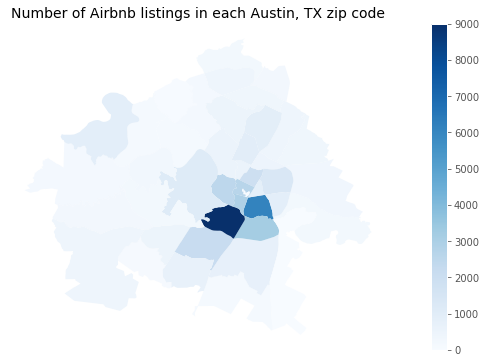

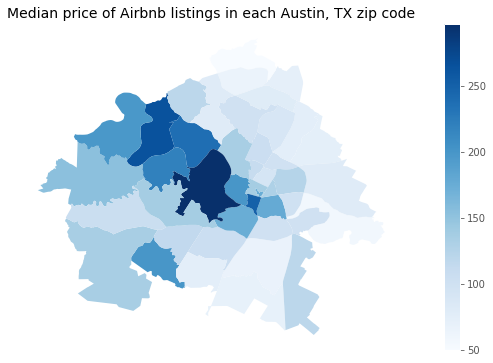

In [5]:
# Plotting the number of listings in each zip code
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
zip_map_df.plot(column='number_of_listings', cmap='Blues', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each Austin, TX zip code', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plotting the median price of listings in each zip code
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
zip_map_df.plot(column='median_price', cmap='Blues', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each Austin, TX zip code', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min(zip_map_df.median_price), vmax=max(zip_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

_**2. What are the most common listing types? (ie: entire home/apartment or shared space?)**_

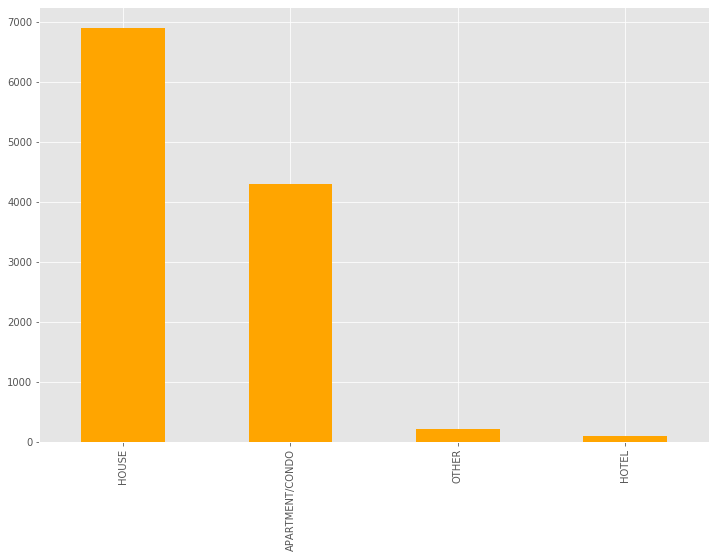

In [6]:
df.property_type.value_counts().plot(kind='bar', color = 'orange')

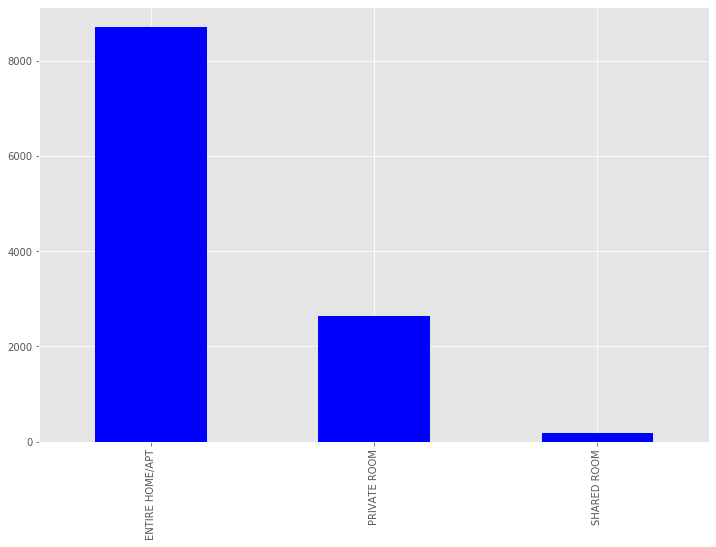

In [7]:
df.room_type.value_counts().plot(kind='bar', color = 'blue')

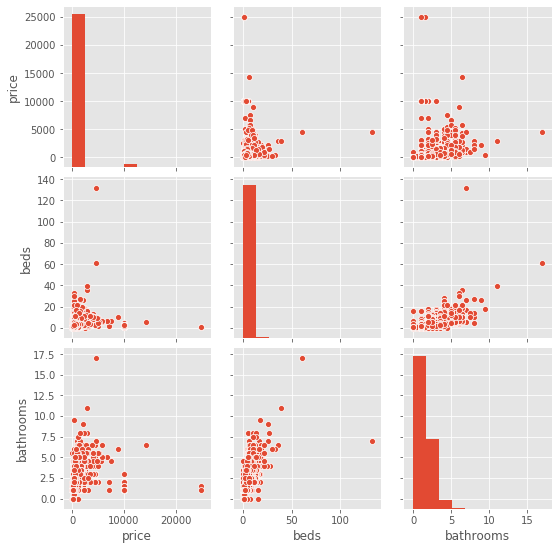

In [8]:
pairplt_features = ['price', 'beds', 'bathrooms']
pairplt_df = df[pairplt_features]
sns.pairplot(pairplt_df)

_**3. How long have different hosts been listing properties through Airbnb and how many listings do host’s have on average?**_